<h1 id="setup" align="center" style="color:white; background-color:#801A9A; padding:10px; border-bottom: 3px solid #460E54;">Setup</h1>

In [4]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pytorch-fid

In [6]:
# pip install paramiko

In [7]:
import os
import shutil
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.io import read_image
import torch.optim as optim

from tqdm import tqdm  # Import tqdm for progress bar
import warnings

<span style="color:#5C5B5B; font-size:1.17em; font-style:italic; border-top:1px solid #5C5B5B; display:block; padding: 0px 5px;">Explanation:</span>

In [9]:
warnings.filterwarnings('ignore')
print('Using PyTorch version', torch.__version__)

# Setup device-agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using PyTorch version 2.2.2+cpu
Using device: cpu


<span style="color:#5C5B5B; font-size:1.17em; font-style:italic; border-top:1px solid #5C5B5B; display:block; padding: 0px 5px;">Explanation:</span>

<h1 id="initiating-image-loading" align="center" style="color:white; background-color:#801A9A; padding:10px; border-bottom: 3px solid #460E54;">Initiating Image Loading</h1>

In [12]:
# img = os.environ["PBS_JOBFS"]
# img

In [13]:
img_dir = "C:/Users/jatin/Desktop/S4/AIHI/T3/Data/archive/Mini-dataset"

In [14]:
attr_df = pd.read_csv('C:/Users/jatin/Desktop/S4/AIHI/T3/Data/archive/list_attr_celeba.csv')
bbox_df = pd.read_csv('C:/Users/jatin/Desktop/S4/AIHI/T3/Data/archive/list_bbox_celeba.csv')
eval_df = pd.read_csv('C:/Users/jatin/Desktop/S4/AIHI/T3/Data/archive/list_eval_partition.csv')
landmarks_df = pd.read_csv('C:/Users/jatin/Desktop/S4/AIHI/T3/Data/archive/list_landmarks_align_celeba.csv')

In [15]:
# Merge dataframes on the image_id
df = attr_df.merge(bbox_df, on='image_id')
df = df.merge(eval_df, on='image_id')
df = df.merge(landmarks_df, on='image_id')

In [16]:
from pathlib import Path

# Assuming 'img_dir' is defined and 'image_id' column contains the image filenames
missing_files = [img for img in df['image_id'] if not Path(os.path.join(img_dir, img)).exists()]
print(f"Missing files: {len(missing_files)}")
if missing_files:
    print("Examples of missing files:", missing_files[:5])

Missing files: 201599
Examples of missing files: ['001001.jpg', '001002.jpg', '001003.jpg', '001004.jpg', '001005.jpg']


In [17]:
df

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,66,114,112,112,86,119,71,147,104,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,...,69,111,108,111,89,140,73,151,104,153
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,...,67,112,110,112,85,141,66,150,110,150
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,69,111,107,111,92,137,68,151,109,153
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,69,111,108,111,90,137,71,153,106,151


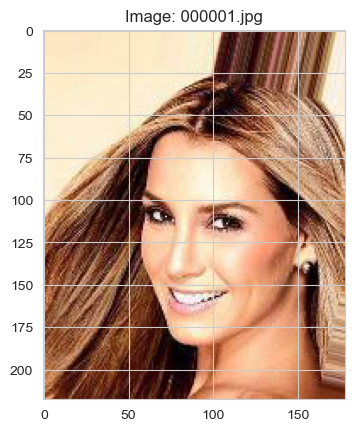

In [18]:
img_filename = df.iloc[0]['image_id']
img_path = os.path.join(img_dir, img_filename)

if os.path.exists(img_path):
    image = Image.open(img_path).convert('RGB')
    plt.imshow(image)
    plt.title(f"Image: {img_filename}")
    plt.show()
else:
    print(f"Image file not found: {img_path}")

<span style="color:#5C5B5B; font-size:1.17em; font-style:italic; border-top:1px solid #5C5B5B; display:block; padding: 0px 5px;">Explanation:</span>

In [20]:
# Define transformations
transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

<span style="color:#5C5B5B; font-size:1.17em; font-style:italic; border-top:1px solid #5C5B5B; display:block; padding: 0px 5px;">Explanation:</span>

In [22]:
# import os
# from PIL import Image
# from torchvision import transforms
# from torch.utils.data import Dataset
# import torch

# class CelebADataset(Dataset):
#     def __getitem__(self, idx):
#         img_filename = self.dataframe.iloc[idx]['image_id']
#         img_path = os.path.join(self.img_dir, img_filename)
#         try:
#             image = Image.open(img_path).convert('RGB')
#         except FileNotFoundError:
#             if self.default_img is not None:
#                 image = Image.open(self.default_img).convert('RGB')  # Load default image
#             else:
#                 raise RuntimeError(f"Default image not provided and image at {img_path} not found.")
    
#         labels = self.dataframe.iloc[idx, 1:].values.astype(int)
#         labels = torch.tensor(labels, dtype=torch.float32)

#         if self.transform:
#             image = self.transform(image)

#         return image, labels


#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         img_filename = self.dataframe.iloc[idx]['image_id']
#         img_path = os.path.join(self.img_dir, img_filename)

#         try:
#             image = Image.open(img_path).convert('RGB')
#         except FileNotFoundError:
#             if self.default_img is not None:
#                 image = Image.open(self.default_img).convert('RGB')  # Load default image
#             else:
#                 return None  # Skip this item or handle it according to your needs

#         labels = self.dataframe.iloc[idx, 1:].values.astype(int)
#         labels = torch.tensor(labels, dtype=torch.float32)

#         if self.transform:
#             image = self.transform(image)

#         return image, labels

In [37]:
class CelebADataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, default_img=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.default_img = default_img

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_filename = self.dataframe.iloc[idx]['image_id']
        img_path = os.path.join(self.img_dir, img_filename)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            if self.default_img:
                image = Image.open(self.default_img).convert('RGB')
            else:
                return None  # Or handle another way that fits the training process

        labels = self.dataframe.iloc[idx, 1:].values.astype(int)
        labels = torch.tensor(labels, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, labels

# Modify DataLoader to skip None entries
def my_collate_fn(batch):
    batch = [item for item in batch if item is not None]
    return torch.utils.data.dataloader.default_collate(batch)

train_loader = DataLoader(df, batch_size=64, shuffle=True, collate_fn=my_collate_fn)

<span style="color:#5C5B5B; font-size:1.17em; font-style:italic; border-top:1px solid #5C5B5B; display:block; padding: 0px 5px;">Explanation:</span>

<h1 id="Visualizing" align="center" style="color:white; background-color:#801A9A; padding:10px; border-bottom: 3px solid #460E54;">Visualizing</h1>

In [41]:
# Utility function to visualize some images
def visualize_samples(dataset, num_samples=5):
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        img, labels = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axs[i].imshow(img)
        axs[i].set_title(f'Labels: {labels.numpy()}')
        axs[i].axis('off')
    plt.show()

TypeError: cannot unpack non-iterable NoneType object

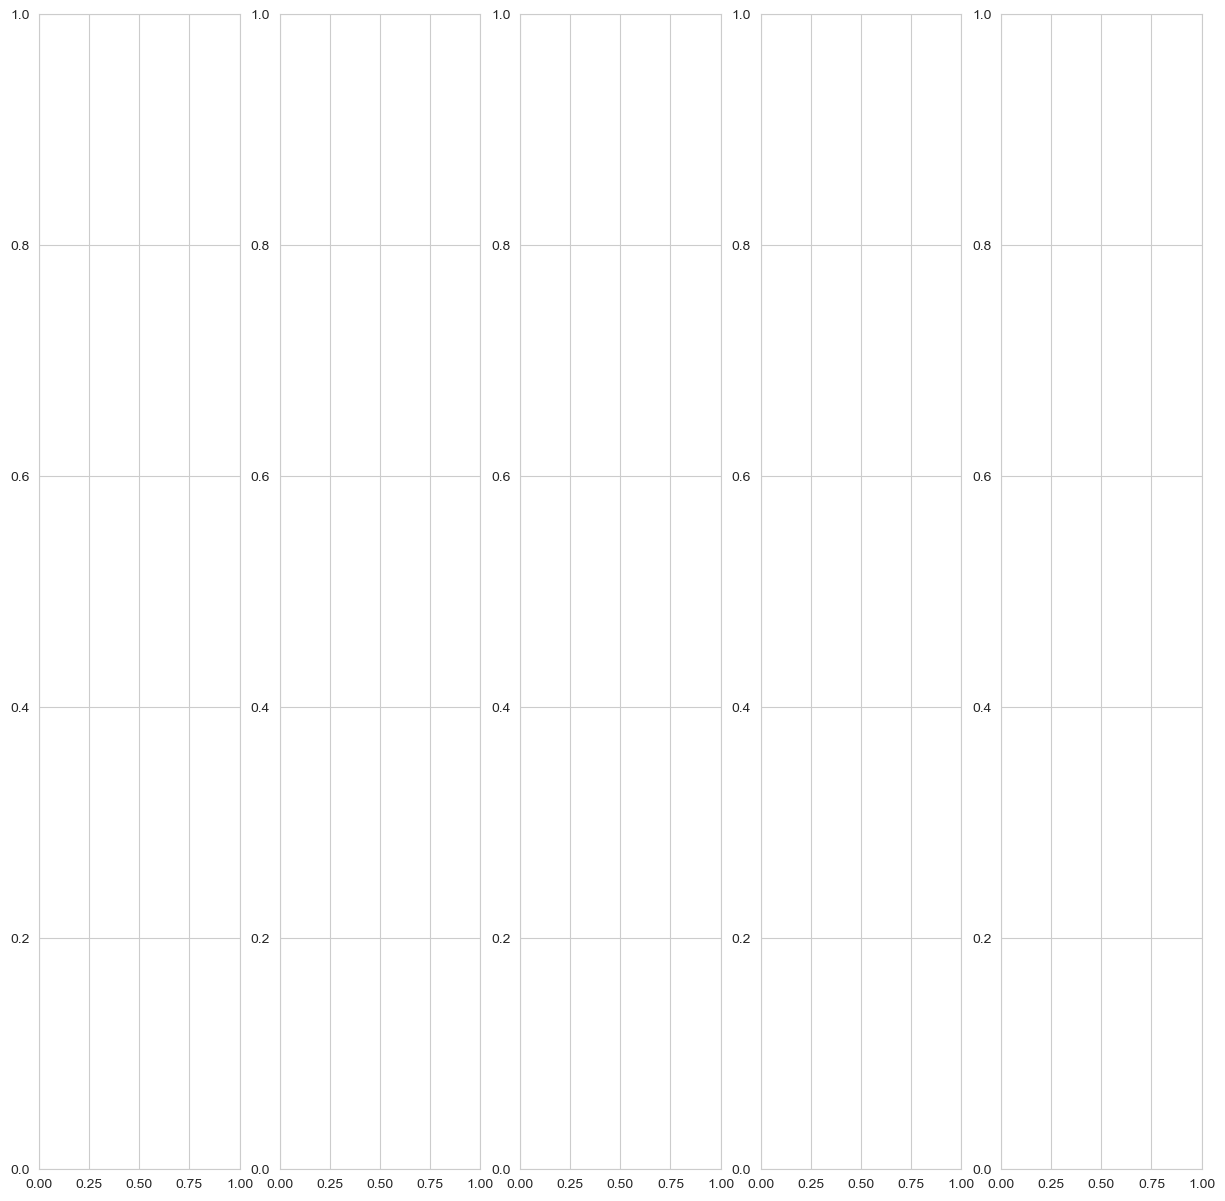

In [43]:
celeba_dataset = CelebADataset(df, img_dir, transformations)
visualize_samples(celeba_dataset, num_samples=5)

In [45]:
sample_path = os.path.join(img_dir, df.iloc[0]['image_id'])
print(sample_path)

C:/Users/jatin/Desktop/S4/AIHI/T3/Data/archive/Mini-dataset\000001.jpg


In [47]:
import os
print(os.listdir(img_dir)[:10])  # Print first 10 files in the directory

['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg']


<h1 id="Model Setup & Development" align="center" style="color:white; background-color:#801A9A; padding:10px; border-bottom: 3px solid #460E54;">Model Setup & Development</h1>

### *INSERT IN 'DATASETS' ABOVE*

In [51]:
# # Initialize the dataset
# dataset = CelebADataset(df, img_dir, transform=transformations)

# # Split the dataset
# train_df = df[df['partition'] == 0]
# val_df = df[df['partition'] == 1]
# test_df = df[df['partition'] == 2]

# train_dataset = CelebADataset(train_df, img_dir, transform=transformations)
# val_dataset = CelebADataset(val_df, img_dir, transform=transformations)
# test_dataset = CelebADataset(test_df, img_dir, transform=transformations)

# # Data loaders
# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# # Check the number of samples in each set
# print(f'Training set size: {len(train_dataset)}')
# print(f'Validation set size: {len(val_dataset)}')
# print(f'Test set size: {len(test_dataset)}')

<span style="color:#5C5B5B; font-size:1.17em; font-style:italic; border-top:1px solid #5C5B5B; display:block; padding: 0px 5px;">Explanation:</span>

<div style="color:#5C5B5B; border-right: 3px solid #5C5B5B; text-align: right; padding: 0px 7px; font-size: 1.17em; font-weight: bold;">Creating Generator & Discriminator</div>

In [55]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.fc(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# Parameters
z_dim = 100  # Dimension of noise vector
data_dim = 28*28  # Example for flattened MNIST images

# Create models
generator = Generator(z_dim, data_dim)
discriminator = Discriminator(data_dim)

<span style="color:#5C5B5B; font-size:1.17em; font-style:italic; border-top:1px solid #5C5B5B; display:block; padding: 0px 5px;">Explanation:</span>

<div style="color:#5C5B5B; border-right: 3px solid #5C5B5B; text-align: right; padding: 0px 7px; font-size: 1.17em; font-weight: normal;"><strong>Optimizers for both</strong> (Generator & Discriminator) and <strong>Gradient penalty function</strong> (for WGAN-GP)</div>


In [60]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# Gradient penalty function for WGAN-GP
def gradient_penalty(discriminator, real_samples, fake_samples):
    alpha = torch.randn(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    fake = torch.ones(d_interpolates.size(), requires_grad=False, device=device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

<span style="color:#5C5B5B; font-size:1.17em; font-style:italic; border-top:1px solid #5C5B5B; display:block; padding: 0px 5px;">Explanation:</span>

In [63]:
train_dataset = CelebADataset(df, img_dir, transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

<span style="color:#5C5B5B; font-size:1.17em; font-style:italic; border-top:1px solid #5C5B5B; display:block; padding: 0px 5px;">Explanation:</span>

<div style="color:#5C5B5B; border-right: 3px solid #5C5B5B; text-align: right; padding: 0px 7px; font-size: 1.17em; font-weight: bold;">Defining Training parameter</div>

In [67]:
num_epochs = 100
lambda_gp = 10  # Gradient penalty lambda hyperparameter

# Training loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Generate fake images
        z = torch.randn(batch_size, noise_dim, 1, 1, device=device)
        fake_images = generator(z)

        # Calculate discriminator loss
        real_validity = discriminator(real_images)
        fake_validity = discriminator(fake_images)
        gp = gradient_penalty(discriminator, real_images.data, fake_images.data)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

        d_loss.backward()
        optimizer_D.step()

        # Train Generator every n_critic steps
        if i % 5 == 0:
            optimizer_G.zero_grad()

            # Generate fake images
            z = torch.randn(batch_size, noise_dim, 1, 1, device=device)
            fake_images = generator(z)

            # Calculate generator loss
            fake_validity = discriminator(fake_images)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

    print(f"Epoch [{epoch}/{num_epochs}]  D Loss: {d_loss.item()}  G Loss: {g_loss.item()}")

    # Save some generated samples periodically
    if epoch % 10 == 0:
        with torch.no_grad():
            z = torch.randn(64, noise_dim, 1, 1, device=device)
            fake_images = generator(z).detach().cpu()
        grid = make_grid(fake_images, nrow=8, normalize=True)
        plt.imshow(grid.permute(1, 2, 0))
        plt.show()

# Save the models
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>

<span style="color:#5C5B5B; font-size:1.17em; font-style:italic; border-top:1px solid #5C5B5B; display:block; padding: 0px 5px;">Explanation:</span>


<h1 id="Training and Optimization" align="center" style="color:white; background-color:#801A9A; padding:10px; border-bottom: 3px solid #460E54;">Training and Optimization</h1>

<span style="color:#5C5B5B; font-size:1.17em; font-style:italic; border-top:1px solid #5C5B5B; display:block; padding: 0px 5px;">Explanation:</span>

<span style="color:#5C5B5B; font-size:1.17em; font-style:italic; border-top:1px solid #5C5B5B; display:block; padding: 0px 5px;">Explanation:</span>

<h1 id="Evaluation" align="center" style="color:white; background-color:#801A9A; padding:10px; border-bottom: 3px solid #460E54;">Evaluation</h1>